# intro

The purpose of this notebook is to load the masks that we made and replicate figure 2 of the Lind 2018 paper. This will require the temperature and salinity fields of all timesteps, and the masks. For each timestep, we will make a mask of shape time, nz, ny, nx that will identify the 3 layers, then for each of these labels (1: surface layer, 2: Arctic layer, 3: Atlantic layer), we take the average temperature and salinity value of this.

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
path = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Lind2018/LindFigures/"

# setup file loading

In [5]:
# load the files we need to do this
# load the timesteps
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

# ocean and ice
AB_gT=0
AB_gS=0

allyears = np.arange(2003,2018,1)
dterm = 10                 # set a terminal depth for freshwater and heat calculations 19:276m   and    10:100m

In [6]:
# load the existing mask of the Barents Sea -- this is what we will work from 
whole = True
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()
mask = ~np.isnan(mymsk)
mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


# create the timeseries

In [8]:
mymsk = np.load('mask_Lind.npz')
mymsk = mymsk['msk1']

In [9]:
# define the layers by temperature
    # surface layer: <100 m depth, T maximum
    # arctic layer: T minimum
    # atlantic layer: T maximum

# find the index of each of these at each column depth and then the midpoint will be halfway between them, then we can create the mask

In [17]:
msktest = np.tile(mymsk[np.newaxis,:,:],(50,1,1))
msktest[msktest == 0] = np.nan
msk3_a = np.tile(msktest[np.newaxis,:,:,:],(12,1,1,1))
msk3_a.shape

(12, 50, 1350, 270)

In [18]:
def identify_ocean_layers(T):
    """
    Identify Surface, Arctic, and Atlantic layers based on temperature extrema
    for a dataset with a time dimension.
    
    Parameters:
    T (numpy array): Temperature array of shape (months, nz, ny, nx).

    Returns:
    dict: Containing depth indices of each layer for each month.
    """
    months, nz, ny, nx = T.shape

    # Identify Arctic Layer (T min per month, per (y, x) profile)
    z_arctic_idx = np.argmin(T, axis=1)  # Shape: (months, ny, nx)

    # Identify Atlantic Layer (T max **only below Arctic Layer**)
    atlantic_mask = np.arange(nz)[None, :, None, None] > z_arctic_idx[:, None, :, :]  # Mask below Arctic
    T_atlantic_layer = np.where(atlantic_mask, T, -np.inf)  # Ignore above-Arctic temperatures
    z_atlantic_idx = np.argmax(T_atlantic_layer, axis=1)  # Find max T below Arctic

    # Identify Surface Layer (Max T **above Arctic Layer**, if it exists)
    surface_mask = np.arange(nz)[None, :, None, None] < z_arctic_idx[:, None, :, :]  # Mask above Arctic
    T_surface_layer = np.where(surface_mask, T, -np.inf)  # Ignore values below Arctic Layer
    z_surface_idx = np.argmax(T_surface_layer, axis=1)  # Find max T above Arctic

    # Handle cases where no valid surface layer exists (e.g., Arctic Layer is at surface)
    z_surface_idx[z_surface_idx >= z_arctic_idx] = 0

    print(z_arctic_idx.shape,z_atlantic_idx.shape,z_surface_idx.shape)

    # do the midpoints to create the mask
    z_surface_arctic_mid = (z_surface_idx + z_arctic_idx) // 2
    z_arctic_atlantic_mid = (z_arctic_idx + z_atlantic_idx) // 2
    
    # Create a mask initialized with zeros
    mask = np.zeros((months, nz, ny, nx), dtype=int)

    # Expand dimensions to match (months, nz, ny, nx)
    depth_levels = np.arange(nz)[None, :, None, None]  # Shape: (1, nz, 1, 1)
    z_surface_arctic_mid = z_surface_arctic_mid[:, None, :, :]  # Shape: (months, 1, ny, nx)
    z_arctic_atlantic_mid = z_arctic_atlantic_mid[:, None, :, :]  # Shape: (months, 1, ny, nx)

    # Assign layer values to mask
    mask[depth_levels <= z_surface_arctic_mid] = 1  # Surface Layer
    mask[(depth_levels > z_surface_arctic_mid) & (depth_levels <= z_arctic_atlantic_mid)] = 2  # Arctic Layer
    mask[depth_levels > z_arctic_atlantic_mid] = 3  # Atlantic Layer

    return mask

# Example usage:
# layers = identify_ocean_layers(THETADR, depths)

In [19]:
# T_test = identify_ocean_layers(T)

In [20]:
# T_mask = T_test * msk3_a

In [21]:
# THETAhere = THETADR * msk3_a * hfC[np.newaxis,:,:,:]
# T_maskhere = T_mask * msk3_a * hfC[np.newaxis,:,:,:]

In [22]:
# plt.pcolormesh(get_aste_tracer(T_maskhere[0],nfx,nfy)[12])
# plt.colorbar()
# plt.xlim(425,525)
# plt.ylim(450,550)

In [23]:
# # Compute mean temperature for each layer as a test
# for i in range(12):
    
#     mean_surface = np.nanmean((THETAhere[i]/DRF3d/hfC)[T_maskhere[i] == 1])  # Surface Layer (1)
#     mean_arctic = np.nanmean((THETAhere[i]/DRF3d/hfC)[T_maskhere[i] == 2])   # Arctic Layer (2)
#     mean_atlantic = np.nanmean((THETAhere[i]/DRF3d/hfC)[T_maskhere[i] == 3]) # Atlantic Layer (3)
    
#     print(f"Mean Surface Temperature: {mean_surface:.2f}")
#     print(f"Mean Arctic Temperature: {mean_arctic:.2f}")
#     print(f"Mean Atlantic Temperature: {mean_atlantic:.2f}")
#     print()

# Great, now we can compute and plot for both salinity and temperature

In [24]:
# do this by looping through the salt and heat -- we want to make an average of these as dept
# do indexing in years for the layers
iy = 0
tavg_surf = np.array([])
tavg_arct = np.array([])
tavg_atl = np.array([])

savg_surf = np.array([])
savg_arct = np.array([])
savg_atl = np.array([])

for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # READ the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    ##########################################################################################
    # identify the layers
    # get the indices of the center value from identify_ocean_layers
    T_idx = identify_ocean_layers(THETADR)
    print("created the indices of the center layers")

    # mask based on the mask we want
    msktest = np.tile(msk3[np.newaxis,:,:],(50,1,1))
    msktest[msktest == 0] = np.nan
    msk3_a = np.tile(msktest[np.newaxis,:,:,:],(12,1,1,1))

    THETAhere = THETADR * msk3_a * hfC[np.newaxis,:,:,:]
    SALThere = SALTDR * msk3_a * hfC[np.newaxis,:,:,:]
    T_maskhere = T_idx * msk3_a * hfC[np.newaxis,:,:,:]

    # for each time in tsstr:

    for i in range(len(tsstr)):
        # get the value
        mean_surfaceT = np.nanmean((THETAhere[i]/DRF3d/hfC)[T_maskhere[i] == 1])  # Surface Layer (1)
        mean_arcticT = np.nanmean((THETAhere[i]/DRF3d/hfC)[T_maskhere[i] == 2])   # Arctic Layer (2)
        mean_atlanticT = np.nanmean((THETAhere[i]/DRF3d/hfC)[T_maskhere[i] == 3]) # Atlantic Layer (3)
        mean_surfaceS = np.nanmean((SALThere[i]/DRF3d/hfC)[T_maskhere[i] == 1])  # Surface Layer (1)
        mean_arcticS = np.nanmean((SALThere[i]/DRF3d/hfC)[T_maskhere[i] == 2])   # Arctic Layer (2)
        mean_atlanticS = np.nanmean((SALThere[i]/DRF3d/hfC)[T_maskhere[i] == 3]) # Atlantic Layer (3)

        #print(mean_surfaceT,mean_arcticT,mean_atlanticT,mean_surfaceS,mean_arcticS,mean_atlanticS)
    
        # append to list
        tavg_surf = np.append(tavg_surf,mean_surfaceT)
        tavg_arct = np.append(tavg_arct,mean_arcticT)
        tavg_atl = np.append(tavg_atl,mean_atlanticT)
        
        savg_surf = np.append(savg_surf,mean_surfaceS)
        savg_arct = np.append(savg_arct,mean_arcticS)
        savg_atl = np.append(savg_atl,mean_atlanticS)

    iy += 1

2003
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2004
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2005
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2006
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2007
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2008
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2009
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2010
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2011
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2012
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created the indices of the center layers
2013
(12, 1350, 270) (12, 1350, 270) (12, 1350, 270)
created

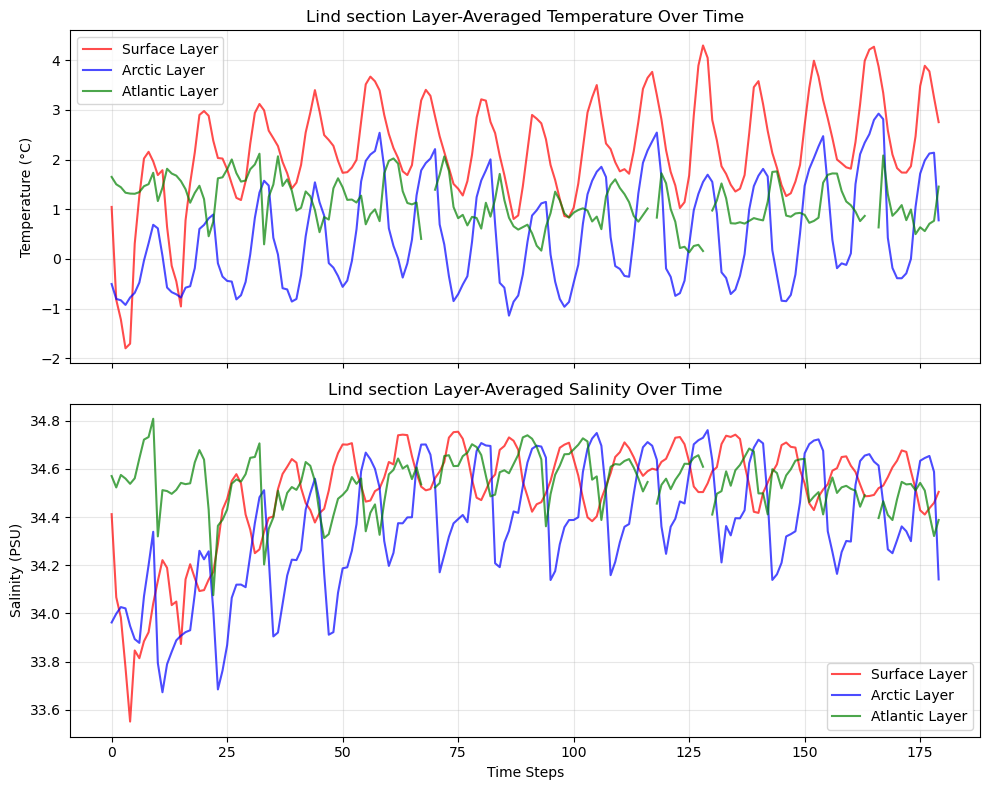

In [25]:
time_steps = np.arange(0, 180, 1)  # X-axis from 0 to 180

# Create figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# First subplot: Temperature trends
axes[0].plot(time_steps, tavg_surf, label="Surface Layer", color="red", alpha=0.7)
axes[0].plot(time_steps, tavg_arct, label="Arctic Layer", color="blue", alpha=0.7)
axes[0].plot(time_steps, tavg_atl, label="Atlantic Layer", color="green", alpha=0.7)
axes[0].set_ylabel("Temperature (°C)")
axes[0].set_title("Lind section Layer-Averaged Temperature Over Time")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Second subplot: Salinity trends
axes[1].plot(time_steps, savg_surf, label="Surface Layer", color="red", alpha=0.7)
axes[1].plot(time_steps, savg_arct, label="Arctic Layer", color="blue", alpha=0.7)
axes[1].plot(time_steps, savg_atl, label="Atlantic Layer", color="green", alpha=0.7)
axes[1].set_ylabel("Salinity (PSU)")
axes[1].set_xlabel("Time Steps")
axes[1].set_title("Lind section Layer-Averaged Salinity Over Time")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig("Lind_3layers_timeseries.png",dpi=300)